In [1]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

In [2]:
#hide
from nbdev.showdoc import *

# Tutorial - Binary classification of chest X-rays

> In this tutorial we will build a classifier that distinguishes between chest X-rays with pneumothorax and chest X-rays without pneumothorax. The image data is loaded directly from the DICOM source files, so no prior DICOM data handling is needed. This tutorial also goes through what DICOM images are and review at a high level how to evaluate the results of the classifier.

## Download and import of X-ray DICOM files

First, we will use the `untar_data` function to download the _siim_small_ folder containing a subset (250 DICOM files, \~30MB) of the [SIIM-ACR Pneumothorax Segmentation](https://doi.org/10.1007/s10278-019-00299-9) \[1\] dataset.
The downloaded _siim_small_ folder will be stored in your _\~/.fastai/data/_ directory. The variable `pneumothorax-source` will store the absolute path to the _siim_small_ folder as soon as the download is complete.

In [3]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [4]:
from pathlib import Path, PurePath, PurePosixPath

In [5]:
import os

In [6]:
localpath = Path('local_copy_dataset/siim_small')

In [7]:
localpath_example = Path('example_modified_image/siim_small')

## What are DICOMs?

In [8]:
items = get_dicom_files(localpath/f"train/")

Pydicom is a python package for parsing DICOM files, making it easier to access the `header` of the DICOM as well as coverting the raw `pixel_data` into pythonic structures for easier manipulation. `fastai.medical.imaging` uses `pydicom.dcmread` to load the DICOM file.

To plot an X-ray, we can select an entry in the `items` list and load the DICOM file with `dcmread`.

In [9]:
patient = 7
xray_sample = items[patient].dcmread()

In [10]:
items[patient]

Path('local_copy_dataset/siim_small/train/No Pneumothorax/000054.dcm')

To view the `header`

In [11]:
xray_sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6840.1517875201.471080
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6840.1517875201.471080
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

Explanation of each element is beyond the scope of this tutorial but [this](http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.3.html#sect_C.7.6.3.1.4) site has some excellent information about each of the entries

Some key pointers on the tag information above:

- **Pixel Data** (7fe0 0010) - This is where the raw pixel data is stored. The order of pixels encoded for each image plane is left to right, top to bottom, i.e., the upper left pixel (labeled 1,1) is encoded first
- **Photometric Interpretation** (0028, 0004) - also known as color space. In this case it is `MONOCHROME2` where pixel data is represented as a single monochrome image plane where low values=dark, high values=bright. If the colorspace was `MONOCHROME` then the low values=bright and high values=dark info.
- **Samples per Pixel** (0028, 0002) - This should be 1 as this image is monochrome. This value would be 3 if the color space was RGB for example
- **Bits Stored** (0028 0101) - Number of bits stored for each pixel sample. Typical 8 bit images have a pixel range between `0` and `255`
- **Pixel Represenation**(0028 0103) - can either be unsigned(0) or signed(1)
- **Lossy Image Compression** (0028 2110) - `00` image has not been subjected to lossy compression. `01` image has been subjected to lossy compression.
- **Lossy Image Compression Method** (0028 2114) - states the type of lossy compression used (in this case `ISO_10918_1` represents JPEG Lossy Compression)
- **Pixel Data** (7fe0, 0010) - Array of 161452 elements represents the image pixel data that pydicom uses to convert the pixel data into an image.

What does `PixelData` look like?

In [12]:
xray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\xa2\x18\x02\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x01\x02\x05\x06\x00\x07\t\x08\xff\xc4\x00[\x10\x00\x02\x01\x03\x03\x02\x04\x03\x06\x04\x02\x06\x05\x06\x06\x13\x01\x02\x11\x00\x03!\x04\x121\x05A\x13"Qa\x062q\x07\x14\x81\x91\xa1\xb1#B\xc1\xd1\x15R\x08$3b\xe1\xf0\x17%Cr\xf1\x165Sde\x95\t'

Because of the complexity in interpreting `PixelData`, pydicom provides an easy way to get it in a convenient form: `pixel_array` which returns a `numpy.ndarray` containing the pixel data:

In [13]:
xray_sample.pixel_array, xray_sample.pixel_array.shape

(array([[  0,   4,   7, ..., 124, 123, 118],
        [  0,   4,   7, ..., 131, 130, 124],
        [  0,   4,   7, ..., 130, 128, 123],
        ...,
        [  0,  39,  60, ...,   7,   7,   7],
        [  2,  34,  52, ...,   5,   5,   5],
        [  0,   3,   0, ...,   0,   0,   0]], dtype=uint8),
 (1024, 1024))

You can then use the `show` function to view the image

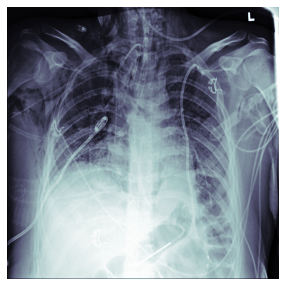

In [14]:
xray_sample.show()

In [15]:
from PIL import Image
import numpy as np
import cv2 as cv

In [16]:
img = Image.fromarray(xray_sample.pixel_array)

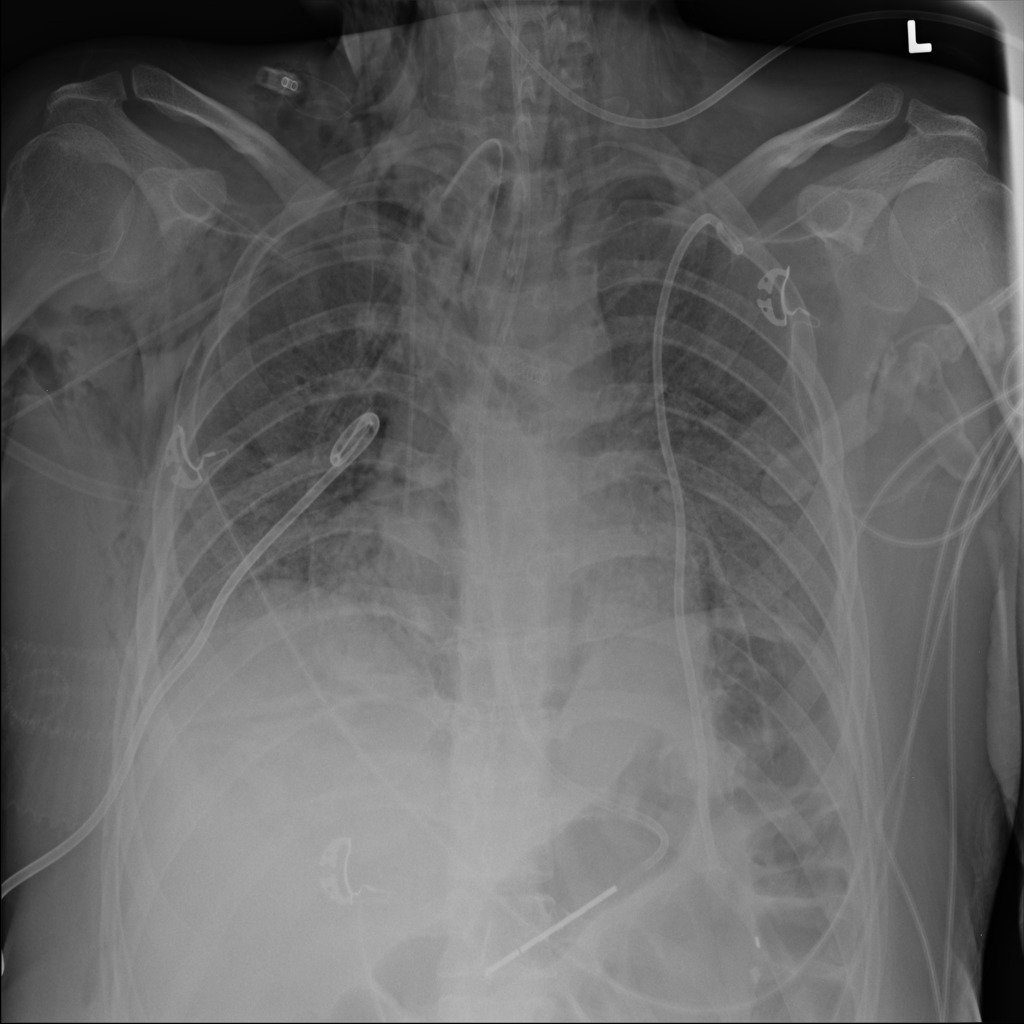

In [17]:
img.show()

In [18]:
x = int((img.shape[1]*0.5+ np.random.rand(1)*img.shape[1]*0.1).item())
y = int((img.shape[0]*0.3+ np.random.rand(1)*img.shape[1]*0.1).item())

In [19]:
img = cv.circle(xray_sample.pixel_array, (x,y), 50, 255, -1)


Our image looks as it should - like a chest x-ray with a coin in the trachea.

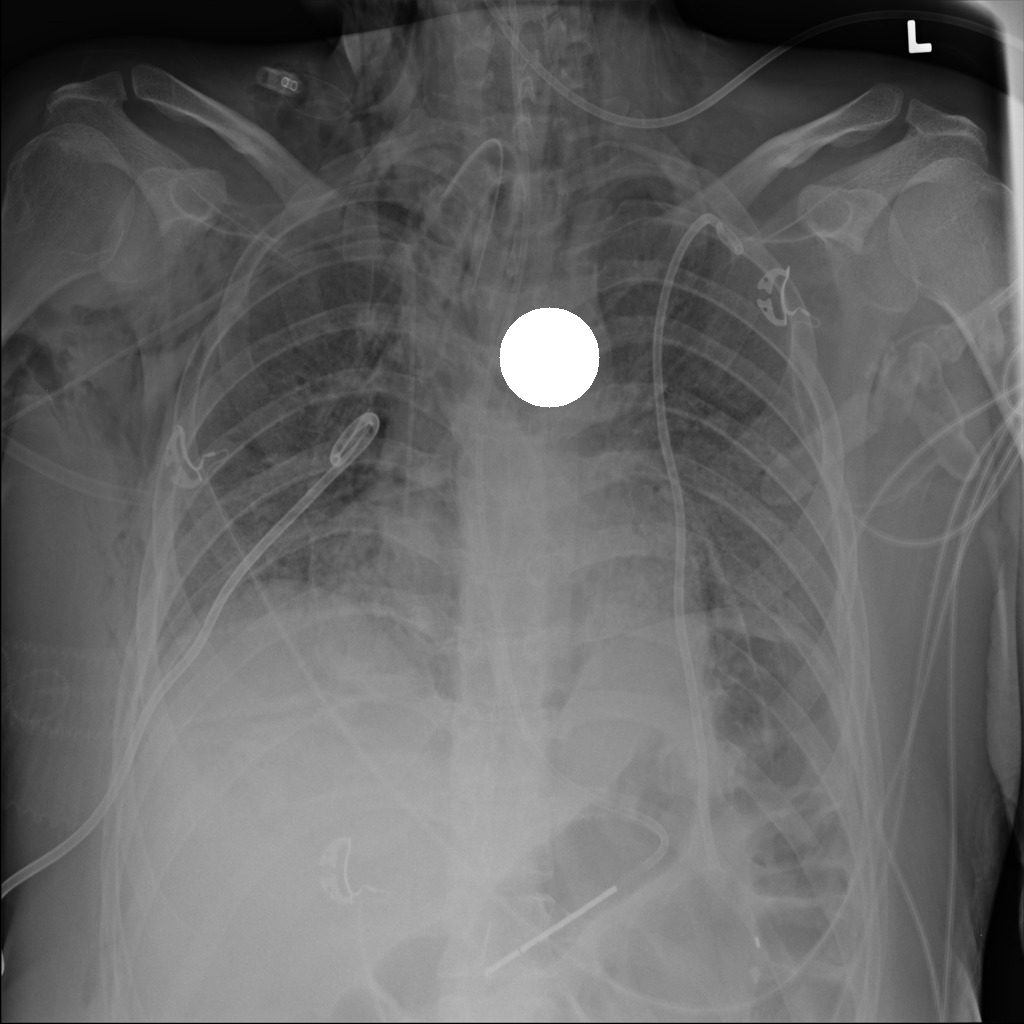

In [20]:
img = Image.fromarray(img)
img.show()

We can confirm that we successfully modified the pixel array.

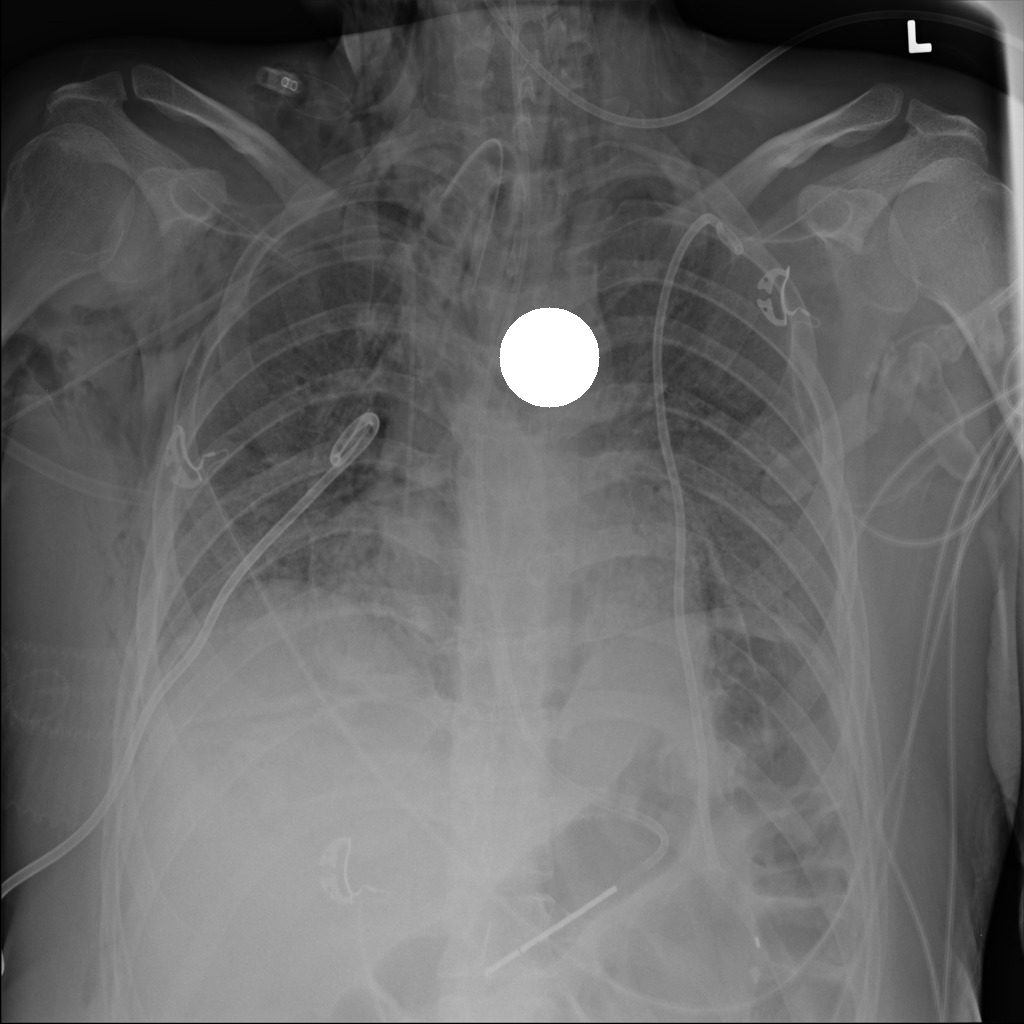

In [21]:
img = Image.fromarray(xray_sample.pixel_array)
img.show()

We can also confirm that when we access the DICOM file via pydicom, that it correctly shows the modified image.

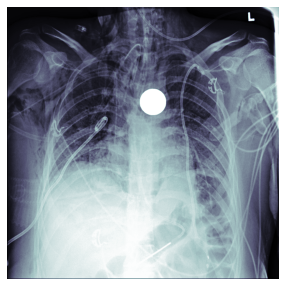

In [22]:
xray_sample.show()

## PixelData vs pixel_array
We need to write to PixelData. This is the encoded pixel data from which pixel array is created. To write back to this attribute, we need to encode the array as string. Unfortunayely, we also lose compression when we do this, so the resultant DICOMs are much bigger in storage size.

In [23]:
xray_sample.PixelData = xray_sample.pixel_array.tostring()

/tmp/ipykernel_1174/755086035.py:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  xray_sample.PixelData = xray_sample.pixel_array.tostring()


In [24]:
from pydicom.uid import ExplicitVRLittleEndian

xray_sample.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

In [25]:
xray_end_path = localpath_example/PurePosixPath('test.dcm')

In [26]:
save_path = xray_end_path

In [27]:
save_path.parent.mkdir(parents=True, exist_ok=True)

In [28]:
xray_sample.save_as(save_path)

In [29]:
testpath = Path(save_path)

In [30]:
test_circle = testpath.dcmread()

We can confirm that when we read back the saved DICOM file, it correctly shows our modification.

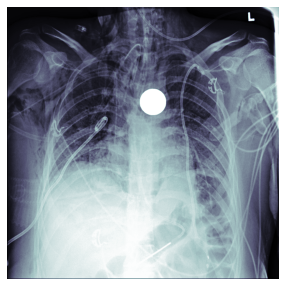

In [31]:
test_circle.show()

In [32]:
test_circle

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 198
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6840.1517875201.471080
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6840.1517875201.471080
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

## Resultant modified image
As you can see, the resultant image is still DICOM, with most of the same key pointers on the tag information. However, it now includes my artificial feature, the white filled circle.

_**Citations:**_

\[1\] Tutorial - Binary classification of chest X-rays. https://docs.fast.ai/tutorial.medical_imaging.html